In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import re

import lightgbm as lgbm
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder


# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve

# Load Data

In [3]:
df_raw = pd.read_csv('data/train_transaction.csv')
df_id = pd.read_csv('data/train_identity.csv')

In [4]:
print('Total number of transactions: {} \nTotal number of Frauds: {}' .format(len(df_raw), np.count_nonzero(df_raw.isFraud)))

Total number of transactions: 590540 
Total number of Frauds: 20663


In [5]:
df = pd.merge(df_raw, df_id, how = 'left', on = 'TransactionID')

In [6]:
df.drop('TransactionID', axis = 1, inplace = True)

In [7]:
del df_raw
del df_id

# Data Exploration

In [8]:
pd.options.display.max_columns = 394
df.head(20)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,...,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.

In [9]:
print('Amount Paid Total:')
df.TransactionAmt.describe().apply("{0:.2f}".format)

Amount Paid Total:


count    590540.00
mean        135.03
std         239.16
min           0.25
25%          43.32
50%          68.77
75%         125.00
max       31937.39
Name: TransactionAmt, dtype: object

In [10]:
print('Amount Paid Only Fraud:')
df.TransactionAmt[df.isFraud == 1].describe().apply("{0:.2f}".format)

Amount Paid Only Fraud:


count    20663.00
mean       149.24
std        232.21
min          0.29
25%         35.04
50%         75.00
75%        161.00
max       5191.00
Name: TransactionAmt, dtype: object

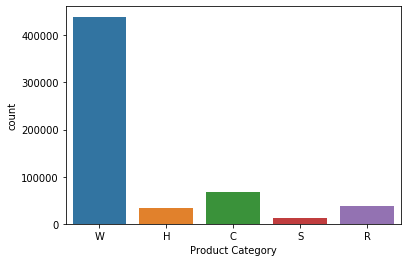

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(df.ProductCD, order = 'WHCSR');
plt.xlabel('Product Category');

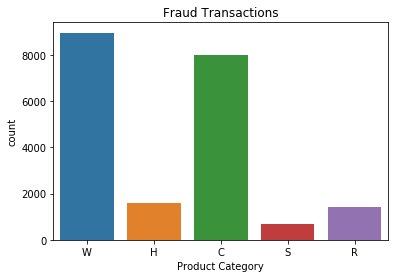

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(df.ProductCD[df.isFraud == 1], order = 'WHCSR');
plt.title('Fraud Transactions');
plt.xlabel('Product Category');

In [13]:
# Columns with the most percentage of missing values
null_vals = pd.DataFrame({'Null_Ratio': df.isnull().sum()/len(df)*100})
null_vals.sort_values(by = 'Null_Ratio', ascending = False, inplace = True)
null_vals.head(20)

,Null_Ratio
id_24,99.196159
id_25,99.130965
id_08,99.127070
id_07,99.127070
id_21,99.126393
id_26,99.125715
id_27,99.124699
id_23,99.124699
id_22,99.124699
dist2,93.628374


In [14]:
pd.value_counts(df.id_18, dropna=False, normalize= True)

NaN     0.923607
15.0    0.043162
13.0    0.022757
12.0    0.007884
18.0    0.001101
20.0    0.000574
17.0    0.000395
26.0    0.000151
21.0    0.000132
24.0    0.000088
11.0    0.000061
27.0    0.000054
29.0    0.000015
23.0    0.000007
14.0    0.000005
16.0    0.000002
25.0    0.000002
28.0    0.000002
10.0    0.000002
Name: id_18, dtype: float64

In [15]:
# Categorical columns
cat_cols = list(df.select_dtypes(include=['object']).columns)
df[cat_cols] = df[cat_cols].astype('category')
cat_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

# Pre-Processing

In [16]:
pd.set_option('display.max_rows', None)
#device_risk

In [17]:
#df['DeviceRisk'] = df.DeviceInfo.apply(lambda row: device_risk[row])

In [18]:
def feat_eng_train(df):
    startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

    df['year'] = df['TransactionDT'].dt.year
    df['month'] = df['TransactionDT'].dt.month
    df['dow'] = df['TransactionDT'].dt.dayofweek
    df['hour'] = df['TransactionDT'].dt.hour
    df['day'] = df['TransactionDT'].dt.day
    df.drop('TransactionDT', axis = 1, inplace = True)

    df.DeviceInfo = df.DeviceInfo.apply(lambda Info: re.split(':| |-|_', str(Info))[0])
    df.DeviceInfo.fillna('nan', inplace = True)

    Value_Counts = df.DeviceInfo.value_counts() 
    df.DeviceInfo.loc[Value_Counts[df.DeviceInfo].values<10] = 'nan'
    all_devices = df.DeviceInfo.unique()

    device_risk = df.DeviceInfo[df.isFraud==1].value_counts()/df.DeviceInfo.value_counts()
    device_risk.fillna(0, inplace = True)

    df['DeviceRisk'] = df.DeviceInfo.apply(lambda row: device_risk[row])


    for col in cat_cols:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

    
    return df, device_risk, all_devices

In [19]:
def preprocess_train(df):

    #df.drop(not_imp_features, axis = 1, inplace = True)
    df, device_risk, all_devices = feat_eng_train(df)
    
    df.fillna(value = -999, inplace = True)
    
    return df, device_risk, all_devices

In [20]:
df, device_risk, all_devices = preprocess_train(df)

# Modeling

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('isFraud', axis = 1), df.isFraud, test_size = 0.2, random_state = 42)

In [22]:
# Weights

tot_num = len(y_train)
Fraud_num = np.count_nonzero(y_train)
nonFraud_num = tot_num- Fraud_num
#weights = {0: 1/Fraud_num*tot_num/2, 1: 1/nonFraud_num*tot_num/2}
weights = nonFraud_num/Fraud_num

In [23]:
def evaluate_preds(y_true, y_preds):
    '''
    Performs evaluation comparison on calssification
    
    '''
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {'accuracy': round(accuracy,2),
                  'precision': round(precision,2),
                  'recall': round(recall,2),
                  'f1': round(f1,2)}

    print(f'Accuracy: {accuracy*100: 0.2f}%')
    print(f'Precision: {precision*100: 0.2f}%')
    print(f'Recall: {recall*100: 0.2f}%')
    print(f'f1: {f1: 0.2f}')
    
    return metric_dict

In [24]:
import xgboost as xgb
import lightgbm as lgb

## Hyper-parametrs

In [25]:
idx = 50000

In [26]:
model_xgb = xgb.XGBClassifier(n_jobs = -1, scale_pos_weight=weights, tree_method='gpu_hist')
model_xgb.fit(X_train[:],y_train[:])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=27.769989647402717, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [58]:
# Create a hyperparameter grid for XGBOOST
xgb_grid = {'subsample': np.arange(0.2,1,0.1)}

In [59]:
# Setup random hyperparameter search for XGBOOST
model_xgb_CV = RandomizedSearchCV(xgb.XGBClassifier(tree_method= 'gpu_hist',
                                                    min_child_weight = 8,
                                                    max_depth= 18,
                                                    eta= 0.005,
                                                    n_jobs= -1,
                                                    scale_pos_weight= 27.769989647402717,
                                                    reg_lambda = 0.21,
                                                    reg_alpha = 0.01,
                                                    learning_rate = 0.2,
                                                    gamma = 0.25,
                                                    colsample_bytree = 0.5), 
                                     param_distributions=xgb_grid,
                                     cv=5,
                                     n_iter=20,
                                     verbose=True)

In [60]:
model_xgb_CV.fit(X_train[:],y_train[:])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 45.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.5, eta=0.005,
                                           gamma=0.25, gpu_id=None,
                                           importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.2,
                                           max_delta_step=None, max_depth=18,
                                           min_child_weight=8, missing=nan,
                                           monotone_constraints=Non...
                                           random_state=None, reg_alpha=0.01,
                                           reg_lambda=0.21,
                                          

In [30]:
y_preds_xgb=model_xgb.predict(X_valid) 
xgb_metrics = evaluate_preds(y_valid, y_preds_xgb)

Accuracy:  92.36%
Precision:  29.58%
Recall:  81.57%
f1:  0.43


In [61]:
y_preds_xgb_CV=model_xgb_CV.predict(X_valid) 
xgb_metrics_CV = evaluate_preds(y_valid, y_preds_xgb_CV)

Accuracy:  98.60%
Precision:  86.31%
Recall:  72.37%
f1:  0.79


In [62]:
compare_preds = pd.DataFrame({'XGBOOST': y_preds_xgb,
                              'XGBOOST_CV': y_preds_xgb_CV})

In [63]:
compare_metrics = pd.DataFrame({'XGBOOST': xgb_metrics,
                                'XGBOOST_CV': xgb_metrics_CV})

In [64]:
def plot_conf_mat(y_test, y_preds, title):
    """
    Plots the confusion matrix using Seaborn's heatmap()
    """
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.title(title)

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom , top)    

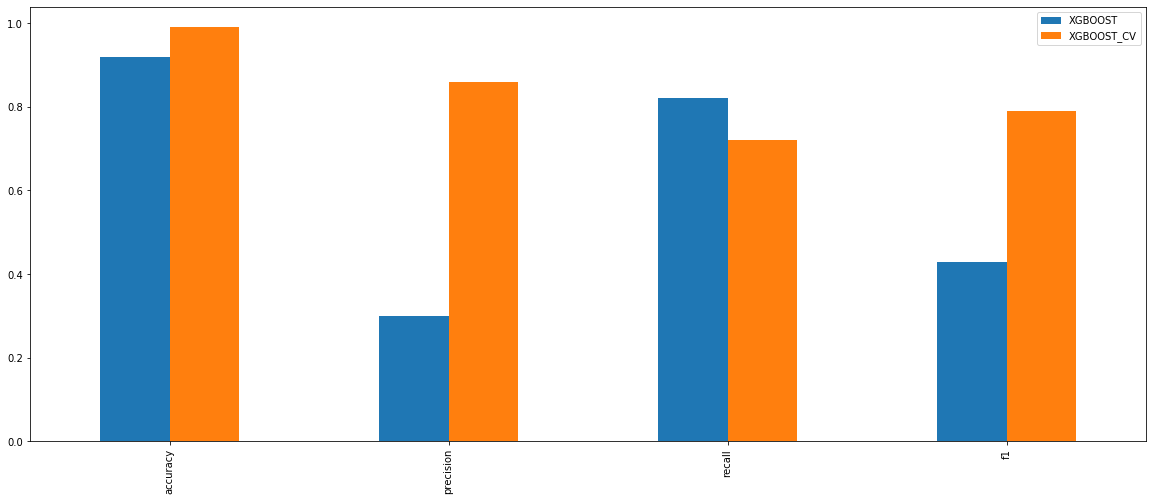

In [65]:
compare_metrics.plot.bar(figsize= (20,8));

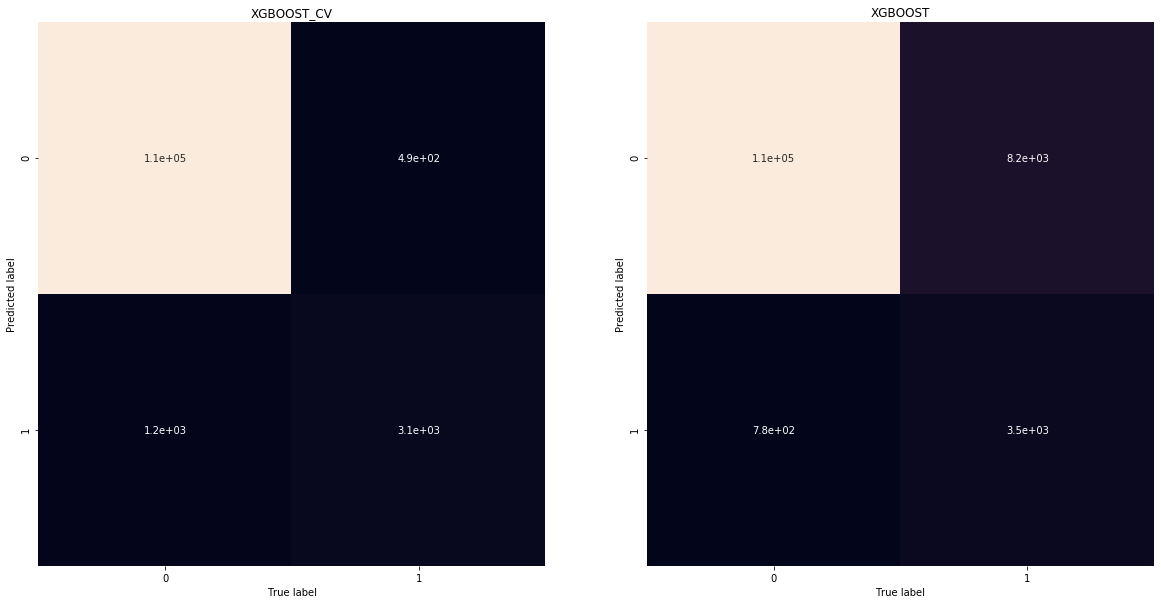

In [66]:
plt.figure(figsize=(20, 10))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    plot_conf_mat(y_valid, compare_preds.iloc[:,i-1], compare_preds.columns[i-1])

In [67]:
best_params = model_xgb_CV.best_params_

In [68]:
best_params['n_jobs'] = -1 
best_params['scale_pos_weight'] = weights
best_params['tree_method'] = 'gpu_hist'

In [95]:
best_params

{'subsample': 0.9000000000000001,
 'n_jobs': -1,
 'scale_pos_weight': 27.769989647402717,
 'tree_method': 'gpu_hist'}

## Fit the whole data

In [96]:
model = xgb.XGBClassifier(tree_method= 'gpu_hist',
                          min_child_weight = 8,
                          max_depth= 18,
                          eta= 0.005,
                          n_jobs= -1,
                          scale_pos_weight= 27.769989647402717,
                          reg_lambda = 0.21,
                          reg_alpha = 0.01,
                          learning_rate = 0.2,
                          gamma = 0.25,
                          colsample_bytree = 0.5)
model.fit(df.drop('isFraud', axis = 1), df.isFraud)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.005, gamma=0.25,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=18,
              min_child_weight=8, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.01,
              reg_lambda=0.21, scale_pos_weight=27.769989647402717, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [97]:
# Make predictions with tuned model
#y_preds = model.predict(X_valid)

In [98]:
#print(classification_report(y_valid, y_preds))

# Test Dataset

In [99]:
def feat_eng_test(df):
    startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

    df['year'] = df['TransactionDT'].dt.year
    df['month'] = df['TransactionDT'].dt.month
    df['dow'] = df['TransactionDT'].dt.dayofweek
    df['hour'] = df['TransactionDT'].dt.hour
    df['day'] = df['TransactionDT'].dt.day
    df.drop('TransactionDT', axis = 1, inplace = True)

    df_test.DeviceInfo = df_test.DeviceInfo.apply(lambda Info: re.split(':| |-|_', str(Info))[0])
    df_test.DeviceInfo.fillna('nan', inplace = True)
    df_test.DeviceInfo.loc[~df_test.DeviceInfo.isin(all_devices)] = 'nan'

    
    df['DeviceRisk'] = df.DeviceInfo.apply(lambda row: device_risk[row])


    for col in cat_cols:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

    
    return df

In [100]:
def preprocess_test(df):

    #df.drop(not_imp_features, axis = 1, inplace = True)
    df = feat_eng_test(df)
    
    df.fillna(value = -999, inplace = True)
    
    return df

In [101]:
df_test_raw = pd.read_csv('data/test_transaction.csv')
df_test_id = pd.read_csv('data/test_identity.csv')

In [102]:
df_test_id.columns = df_test_id.columns.str.replace('-','_')

In [103]:
df_test = pd.merge(df_test_raw, df_test_id, how = 'left', on = 'TransactionID')

In [104]:
submission_df = pd.DataFrame(columns=['TransactionID']+['isFraud'])

In [105]:
submission_df['TransactionID']= list(df_test.TransactionID)

In [106]:
df_test.drop('TransactionID', axis = 1, inplace = True)

In [107]:
df_test = preprocess_test(df_test)

In [108]:
y_preds = model.predict_proba(df_test)

In [109]:
submission_df['isFraud'] = y_preds[:, 1]

In [110]:
submission_df.to_csv('Submission/Submission_xgb10.csv', index = False)